In [98]:
# handle datasets
import pandas as pd
import numpy as np
# plotting
import matplotlib.pyplot as plt
# yeo-johnson transformation
import scipy.stats as stats
# save the model
import joblib

In [99]:
# load train data
data = pd.read_csv('../datasets/test.csv')
print(data.shape)
data.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [100]:
data.drop('Id', axis=1, inplace=True)
print(data.shape)

(1459, 79)


In [101]:
# categorical variables

data['MSSubClass'] = data['MSSubClass'].astype('O')

with_string_missing = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

with_frequent_category = {
    'MasVnrType': 'None',
    'BsmtQual': 'TA',
    'BsmtCond': 'TA',
    'BsmtExposure': 'No',
    'BsmtFinType1': 'Unf',
    'BsmtFinType2': 'Unf',
    'Electrical': 'SBrkr',
    'GarageType': 'Attchd',
    'GarageFinish': 'Unf',
    'GarageQual': 'TA',
    'GarageCond': 'TA',
}

In [102]:
# replace missing value with new label "Missing"
data[with_string_missing] = data[with_string_missing].fillna('Missing')

In [103]:
# replace missing values with the most frequent category
for var in with_frequent_category.keys():
    data[var].fillna(with_frequent_category[var], inplace=True)

C:\Users\chafu\AppData\Local\Temp\ipykernel_28180\4186119874.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[var].fillna(with_frequent_category[var], inplace=True)


In [104]:
# numerical values

# dictionarty with hard-coded mean values
vars_with_na = {
    'LotFrontage': 69.87974098057354,
    'MasVnrArea': 103.7974006116208,
    'GarageYrBlt': 1978.2959677419356
}

# replace missing values by the mean and add binary missing indicator
for var in vars_with_na.keys():
    data[var+'_na'] = np.where(data[var].isnull(), 1, 0)
    data[var].fillna(vars_with_na[var], inplace=True)

C:\Users\chafu\AppData\Local\Temp\ipykernel_28180\1562493701.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[var].fillna(vars_with_na[var], inplace=True)
C:\Users\chafu\AppData\Local\Temp\ipykernel_28180\1562493701.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [105]:
# numerical transformations
for var in ['LotFrontage', '1stFlrSF', 'GrLivArea']:
    data[var] = np.log(data[var])

data['LotArea'] = stats.yeojohnson(data['LotArea'], lmbda=0.017755558882009546)

In [106]:
# skewed varibles
skewed = ['BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch', '3SsnPorch',
          'ScreenPorch', 'MiscVal']

for var in skewed:
    data[var] = np.where(data[var]==0, 0, 1)

In [107]:
# temporal variables

def elapsed_years(df, var):
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    data = elapsed_years(data, var)

data.drop(['YrSold'], axis=1, inplace=True) 

In [108]:
# categorical variables mappings

qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0,
                 'NA': 0}
qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
             'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']

for var in qual_vars:
    data[var] = data[var].map(qual_mappings)   

exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4, 'Missing': 0, 'NA': 0}
var = 'BsmtExposure'
data[var] = data[var].map(exposure_mappings)

fisish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 2,
                   'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
finish_vars = ['BsmtFinType1', 'BsmtFinType2']
for var in finish_vars:
    data[var] = data[var].map(fisish_mappings)

garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
var = 'GarageFinish'
data[var] = data[var].map(garage_mappings)

fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3,
                  'GdPrv': 4}
var = 'Fence'
data[var] = data[var].map(fence_mappings)

In [109]:
# most frequent categories

frequent_ls = {
    'MSZoning': ['FV', 'RH', 'RL', 'RM'],
    'Street': ['Pave'],
    'Alley': ['Grvl', 'Missing', 'Pave'],
    'LotShape': ['IR1', 'IR2', 'Reg'],
    'LandContour': ['Bnk', 'HLS', 'Low', 'Lvl'],
    'Utilities': ['AllPub'],
    'LotConfig': ['Corner', 'CulDSac', 'FR2', 'Inside'],
    'LandSlope': ['Gtl', 'Mod'],
    'Neighborhood': ['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
        'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
        'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
        'Somerst', 'StoneBr', 'Timber'],
    'Condition1': ['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'],
    'Condition2': ['Norm'],
    'BldgType': ['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'],
    'HouseStyle': ['1.5Fin', '1Story', '2Story', 'SFoyer', 'SLvl'],
    'RoofStyle': ['Gable', 'Hip'],
    'RoofMatl': ['CompShg'],
    'Exterior1st': ['AsbShng', 'BrkFace', 'CemntBd', 'HdBoard', 'MetalSd', 'Plywood',
        'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],
    'Exterior2nd': ['AsbShng', 'BrkFace', 'CmentBd', 'HdBoard', 'MetalSd', 'Plywood',
        'Stucco', 'VinylSd', 'Wd Sdng', 'Wd Shng'],
    'MasVnrType': ['BrkFace', 'Missing', 'Stone'],
    'Foundation': ['BrkTil', 'CBlock', 'PConc', 'Slab'],
    'Heating': ['GasA', 'GasW'],
    'CentralAir': ['N', 'Y'],
    'Electrical': ['FuseA', 'FuseF', 'SBrkr'],
    'Functional': ['Min1', 'Min2', 'Mod', 'Typ'],
    'GarageType': ['Attchd', 'Basment', 'BuiltIn', 'Detchd'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['Missing'],
    'MiscFeature': ['Missing', 'Shed'],
    'SaleType': ['COD', 'New', 'WD'],
    'SaleCondition': ['Abnorml', 'Family', 'Normal', 'Partial'],
    'MSSubClass': ['20', '30', '50', '60', '70', '75', '80', '85', '90', '120', '160', '190'],
}

In [110]:
for var in frequent_ls.keys():
    data[var] = np.where(data[var].isin(frequent_ls), data[var], 'Rare')

In [111]:
# encoding categorical variables

ordinal_mappings = {
    'MSZoning': {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4},
    'Street': {'Rare': 0, 'Pave': 1},
    'Alley': {'Grvl': 0, 'Pave': 1, 'Missing': 2},
    'LotShape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
    'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
    'Utilities': {'Rare': 0, 'AllPub': 1},
    'LotConfig': {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4},
    'LandSlope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
    'Neighborhood': {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3,
                    'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7,
                    'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11,
                    'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15,
                    'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19,
                    'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22},
    'Condition1': {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5},
    'Condition2': {'Rare': 0, 'Norm': 1},
    'BldgType': {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fam': 3, 'TwnhsE': 4},
    'HouseStyle': {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, '1Story': 3, 'SLvl': 4, '2Story': 5},
    'RoofStyle': {'Gable': 0, 'Rare': 1, 'Hip': 2},
    'RoofMatl': {'CompShg': 0, 'Rare': 1},
    'Exterior1st': {'AsbShng': 0, 'Wd Sdng': 1, 'WdShing': 2, 'MetalSd': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CemntBd': 9, 'VinylSd': 10},
    'Exterior2nd': {'AsbShng': 0, 'Wd Sdng': 1, 'MetalSd': 2, 'Wd Shng': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CmentBd': 9, 'VinylSd': 10},
    'MasVnrType': {'Rare': 0, 'Missing': 1, 'BrkFace': 2, 'Stone': 3},
    'Foundation': {'Slab': 0, 'BrkTil': 1, 'CBlock': 2, 'Rare': 3, 'PConc': 4},
    'Heating': {'Rare': 0, 'GasW': 1, 'GasA': 2},
    'CentralAir': {'N': 0, 'Y': 1},
    'Electrical': {'Rare': 0, 'FuseF': 1, 'FuseA': 2, 'SBrkr': 3},
    'Functional': {'Rare': 0, 'Min2': 1, 'Mod': 2, 'Min1': 3, 'Typ': 4},
    'GarageType': {'Rare': 0, 'Detchd': 1, 'Basment': 2, 'Attchd': 3, 'BuiltIn': 4},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'PoolQC': {'Missing': 0, 'Rare': 1},
    'MiscFeature': {'Rare': 0, 'Shed': 1, 'Missing': 2},
    'SaleType': {'COD': 0, 'Rare': 1, 'WD': 2, 'New': 3},
    'SaleCondition': {'Rare': 0, 'Abnorml': 1, 'Family': 2, 'Normal': 3, 'Partial': 4},
    'MSSubClass': {'30': 0, 'Rare': 1, '190': 2, '90': 3, '160': 4, '50': 5,'85': 6,
                '70': 7, '80': 8, '20': 9, '75': '10', '120': 11, '60': 12}
}

In [112]:
for var in ordinal_mappings.keys():
    data[var] = data[var].map(ordinal_mappings[var])

In [113]:
with_null = [var for var in data.columns if data[var].isnull().sum() > 0]
len(with_null)

13

In [114]:
'''
There are still missing data that was not covered by the mappings,
so will need to fill them with zeros, since the scaler won't deal
with missing values
'''

data.fillna(0, inplace=True)

In [115]:
# scaling
scaler = joblib.load('minmax_scaler.joblib')

data = pd.DataFrame(
    scaler.transform(data),
    columns=data.columns
)

In [116]:
data.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.083333,0.0,0.495064,0.417574,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.75,0.0,0.0,0.454545,0.333333,0.0,0.0,0.0,0.0
1,0.083333,0.0,0.499662,0.457509,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.00,0.0,1.0,0.454545,0.333333,0.0,0.0,0.0,0.0
2,0.083333,0.0,0.466207,0.451441,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.75,0.0,0.0,0.181818,0.333333,0.0,0.0,0.0,0.0


In [117]:
# load the selected features
features = pd.read_csv('selected_features.csv')
features = features['0'].to_list()

data = data[features]
print(data.shape)

(1459, 37)


<Axes: >

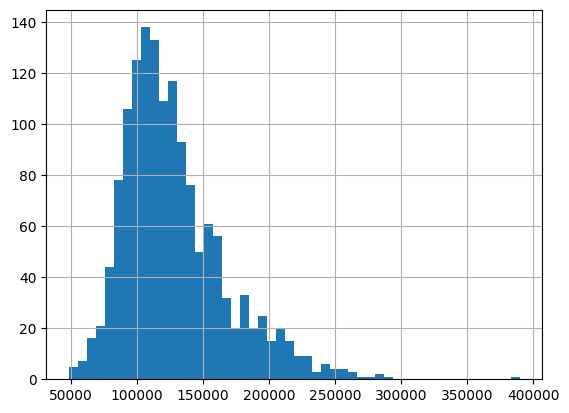

In [118]:
# load the trained model
lin_model = joblib.load('linear_regression.joblib')

# prediction
pred = lin_model.predict(data)

# plot predicted sale prices
pd.Series(np.exp(pred)).hist(bins=50)